# **DNN Plant Classification Model**

## **Introduction**
The use of deep learning to classify images has become very common in recent years. The main reasons for this are:
1. the increase in the **computing power available** to everyone.
2.  the various libraries that allow valuable operations to be performed in a relatively easy way.
3. the vast amount of information available on the Internet on the subject.

However, **deep learning requires a relatively large dataset** when the minimum amount of images required can be on the order of several thousand images. (for example see [this](https://arxiv.org/abs/2010.08186) paper or [this](https://petewarden.com/2017/12/14/how-many-images-do-you-need-to-train-a-neural-network/) blog). This fact can be a barrier to problems that do not have an existing data set and need to be created from scratch.

My master project focuses on the environmental impacts of green walls in enclosed spaces using image processing as well as artificial intelligence tools. For this purpose I try to monitor the activity of the vegetation and its environmental impact. Photosynthesis affects the reduction of carbon dioxide concentrations in the room, transpiration affects the reduction of temperature and relative humidity, etc. (for example look [this paper](https://www.mdpi.com/2673-4931/2/1/56))

In order to distinguish between the different effects of different plants I want to create a model that identify and separate the different species of plants on the green wall.

Since I do not have a dataset of images of these species, I will try to create a data set based on **split-image videos**. While taking thousands of photos takes a long time, splitting images from video is a quick and easy process.

I will use the data set to produce a model for classifying images using a neural network (DNN) and I will diagnose the accuracy and effectiveness of this method.


## **Methods**
In order to colect the data, I used a GALAXY A12 smartphone camera. Images were collected on **different days** and **different lighting conditions**. For each species of plants about **1000 images were collected** for training the model. The images were taken by using video and split them into individual frames. Three different models were created:
1. The first model used images collected using **video for both training and validation**.
2. In order to see the difference in performance between a model that was trained on video and a model that was also trained on "normal" images, another 100 images for each species were collected manually on which the model performed validation.
3. Another model **without hidden layers** was also tested in order to test its performance.

The three models use the **TensorFlow and Keras** libraries.you can find the links to the code in the Bibliography.

After developing the various models, they will be tested on another **test set** that the model has never seen. This method is common in order to sure we had no overfitting of the model.

## **Pre proccesing of data**

**Spliting the videos:**

I used this function to split a video and store the images into folder:

In [ ]:
import cv2
import time
import os

def video_to_frames(input_loc, output_loc):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        if not ret:
            continue
        # Write the results back to output location.
        cv2.imwrite(output_loc + "/%#09d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break

if __name__=="__main__":

    input_loc = ''
    output_loc = ''
    video_to_frames(input_loc, output_loc)

If you want to use GPU on Google colab run this to ensure that eveything is ok

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.7.0
Hub version: 0.12.0
GPU is available


In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/pictures/RGB_wall/training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6171 files belonging to 6 classes.


In [ ]:
# let's check the cllasses names:
class_names = dataset.class_names
class_names

['Chlorophitum',
 'Monalisa',
 'Peperomia',
 'Philodendron',
 'Spathiphyllum',
 'Tradescantia']

In [ ]:
# Now all the data is arrange in  batches:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape) # shape of the batch (count, size, channels)
    print(labels_batch.numpy()) #(label = class)

(32, 256, 256, 3)
[0 0 4 1 3 4 5 4 5 5 2 3 3 5 2 1 5 1 5 3 4 3 3 3 4 2 3 4 2 0 1 3]


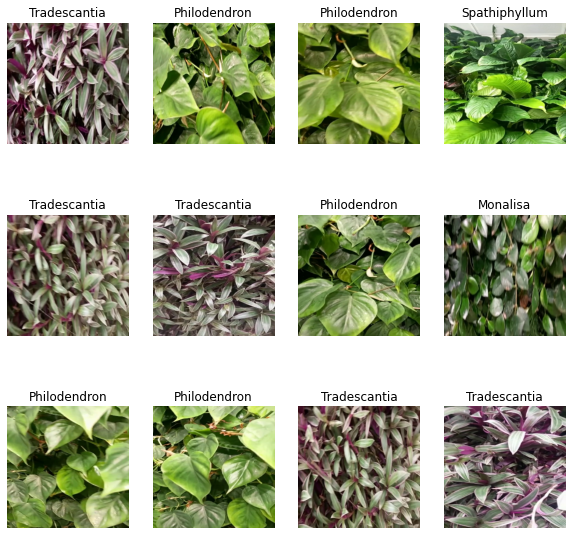

In [ ]:
# Visualize some of the images from our dataset:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

We will now split our data set into 2 sub-sets:
  **90% of the dataset** will be used for **training** the model and **10%** will be used for **validation**.

In addition, we created a folder of 100 images for each species with which we will **Test the model**. We will not take the images that will be used for the test from the images we created with the help of the video because this is our way of assessing whether creating model by splitting video will be effective for classifying images.


Finally we will be left with 3 subsets:
1. **Train set**
2. **Validation set**
3. **Test set** 

In [ ]:
# function who split the data into train set and vlidation set:
# when we dont want to split the data we eill use dataset = train_ds
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)

    
    return train_ds, val_ds

In [ ]:
train_ds, val_ds = get_dataset_partitions_tf(dataset) # apply the function om our dataset

In [ ]:
# if we want to valid the model with different images (model 2):
train_ds = dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/pictures/RGB_wall/validation",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 621 files belonging to 6 classes.


In [ ]:
# now we want to import the test set that we created in seperate:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/pictures/RGB_wall/test",
    seed=123,
    shuffle=False, #keep it false for the confiusion matrix
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 107 files belonging to 6 classes.


In [ ]:
# prefetch - using the cpu to read the data ang gpu to train simultany - save time/
# cache - save time while loading the images
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## **Model 1 and Model 2**

In [ ]:
# resize to 256*256, rescale the values

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# flip the images for improving the accuracy of the model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
193/193 [==============================] - 1259s 4s/step - loss: 0.9752 - accuracy: 0.5766 - val_loss: 0.8260 - val_accuracy: 0.7118
Epoch 2/20
193/193 [==============================] - 704s 4s/step - loss: 0.3054 - accuracy: 0.8799 - val_loss: 0.9747 - val_accuracy: 0.8132
Epoch 3/20
193/193 [==============================] - 701s 4s/step - loss: 0.1565 - accuracy: 0.9443 - val_loss: 1.6379 - val_accuracy: 0.7729
Epoch 4/20
193/193 [==============================] - 697s 4s/step - loss: 0.0735 - accuracy: 0.9742 - val_loss: 1.7571 - val_accuracy: 0.8132
Epoch 5/20
193/193 [==============================] - 698s 4s/step - loss: 0.0469 - accuracy: 0.9904 - val_loss: 2.6163 - val_accuracy: 0.5523
Epoch 6/20
193/193 [==============================] - 720s 4s/step - loss: 0.1017 - accuracy: 0.9681 - val_loss: 0.9041 - val_accuracy: 0.8116
Epoch 7/20
193/193 [==============================] - 726s 4s/step - loss: 0.0210 - accuracy: 0.9922 - val_loss: 2.2987 - val_accuracy: 0.756

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
val_acc

[0.7117552161216736,
 0.8132045269012451,
 0.772946834564209,
 0.8132045269012451,
 0.5523349642753601,
 0.8115941882133484,
 0.7568438053131104,
 0.8550724387168884,
 0.8695651888847351,
 0.8115941882133484,
 0.8486312627792358,
 0.8502415418624878,
 0.8856682777404785,
 0.8985507488250732,
 0.8856682777404785,
 0.8921095132827759,
 0.8856682777404785,
 0.9001610279083252,
 0.9001610279083252,
 0.8276972770690918]

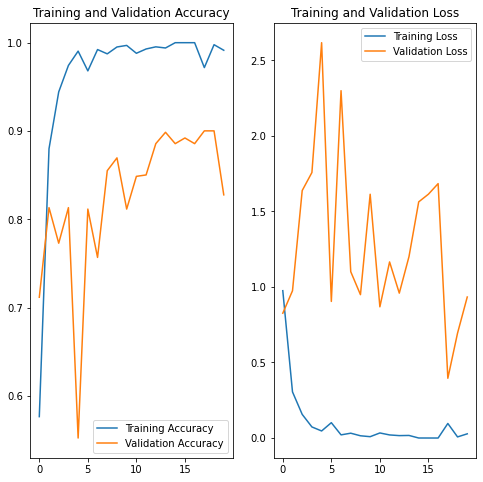

In [ ]:
# Plot the procces of the trainig and validating of the model
len_epoch = 20
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len_epoch),acc, label='Training Accuracy')
plt.plot(np.arange(len_epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len_epoch), loss, label='Training Loss')
plt.plot(np.arange(len_epoch), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now we can save the model.I did it 2 times because i run 2 different models as i mention before

In [ ]:
# saving the model when the validation images splited from video:
# model.save("/content/drive/MyDrive/gdrive_folder/models/GW_classification.h1")

# saving the model when the validation was taken in separate:
model.save("/content/drive/MyDrive/gdrive_folder/models/GW_classification.h2_valid_real_images")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/gdrive_folder/models/GW_classification.h2_valid_real_images/assets


## **Model 3 - Build-in model**

More on this code you can look [here](/https://www.tensorflow.org/hub/tutorials/tf2_image_retraining)

First we need to Apply the GPU mode (Runtime -> Change Runtime type -> GPU)

In [ ]:

import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.7.0
Hub version: 0.12.0
GPU is available


Here you can choose different models:

In [ ]:

model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


Now we need to load the data as below (train_ds,val_ds,test_ds), here the test set and validation set are both from video who splitted

In [ ]:
data_dir="/content/drive/Othercomputers/My Computer/Desktop/Greenwall/pictures/RGB_wall/training"
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      subset=subset,
      validation_split=.2,
      label_mode="categorical",
      shuffle= True,
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=(pixels, pixels),
      batch_size=BATCH_SIZE)
# input_maps = tf.image.resize_images(input_maps, (image_size[0], image_size[1]))
train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 6171 files belonging to 6 classes.
Using 4937 files for training.
Found 6171 files belonging to 6 classes.
Using 1234 files for validation.


In [ ]:
class_names

('Chlorophitum',
 'Monalisa',
 'Peperomia',
 'Philodendron',
 'Spathiphyllum',
 'Tradescantia')

In [ ]:
do_fine_tuning = False

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=(pixels, pixels) + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+(pixels, pixels)+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 207,623,518
Trainable params: 7,686
Non-trainable params: 207,615,832
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5
19/19 [==============================] - 158s 5s/step - loss: 1.4830 - accuracy: 0.8388 - val_loss: 1.2759 - val_accuracy: 1.0000
Epoch 2/5
19/19 [==============================] - 80s 4s/step - loss: 1.3166 - accuracy: 0.9638 - val_loss: 1.1285 - val_accuracy: 0.8906
Epoch 3/5
19/19 [==============================] - 80s 4s/step - loss: 0.9807 - accuracy: 0.9539 - val_loss: 0.7715 - val_accuracy: 1.0000
Epoch 4/5
19/19 [==============================] - 80s 4s/step - loss: 0.7831 - accuracy: 0.9737 - val_loss: 0.6218 - val_accuracy: 1.0000
Epoch 5/5
19/19 [==============================] - 80s 4s/step - loss: 0.6745 - accuracy: 0.9671 - val_loss: 0.5623 - val_accuracy: 1.0000


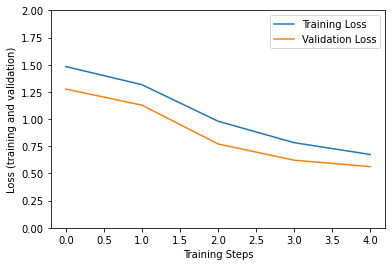

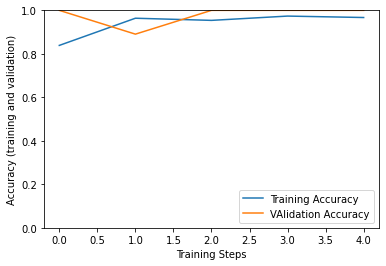

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"],label='Training Loss')
plt.plot(hist["val_loss"],label='Validation Loss')
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"],label='Training Accuracy')
plt.plot(hist["val_accuracy"],label='VAlidation Accuracy')
plt.legend(loc='lower right')

In [ ]:
# Saving the model
model.save("/content/drive/MyDrive/gdrive_folder/models/GW_classification_efficientnetv2-xl-21k")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/gdrive_folder/models/GW_classification_efficientnetv2-xl-21k/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/gdrive_folder/models/GW_classification_efficientnetv2-xl-21k/assets


## **Results**

In [ ]:
# Loading the models
model = tf.keras.models.load_model("/content/drive/MyDrive/gdrive_folder/models/GW_classification.h1")
model1 = tf.keras.models.load_model("/content/drive/MyDrive/gdrive_folder/models/GW_classification.h2_valid_real_images")
model2 = tf.keras.models.load_model("/content/drive/MyDrive/gdrive_folder/models/GW_classification_efficientnetv2-xl-21k")

For the efficientnetv2-xl-21k model we will load the test data set in diffwerent way. (Its the same data but different way. otherwise its will not work)

In [ ]:
# create a data generator
datagen = ImageDataGenerator()
#  load and iterate test dataset
test_it = datagen.flow_from_directory('/content/drive/Othercomputers/My Computer/Desktop/Greenwall/pictures/RGB_wall/test', class_mode='categorical',target_size=(512, 512), batch_size=32)


Found 107 images belonging to 6 classes.


In [ ]:
score_video_set = model.evaluate(test_ds)
score_manualy_set = model1.evaluate(test_ds)

7/7 [==============================] - 5s 690ms/step - loss: 0.6271 - accuracy: 0.8879


In [ ]:
score_efficientnetv2 = model2.evaluate(test_it)

4/4 [==============================] - 52s 10s/step - loss: 859140.4375 - accuracy: 0.2056


As we can see **the accuracy of this model is very low**. We will discuss it later

In [ ]:
print("validation on video images score loss:",score_video_set[0], ", validation: ",score_video_set[1])
print("validation on manually image score loss:",score_manualy_set[0], ", validation: ",score_manualy_set[1])

validation on video images score loss: 0.7321523427963257 , validation:  0.8598130941390991
validation on manually image score loss: 0.6271169781684875 , validation:  0.8878504633903503


Now lets present some of the results:
we will present the results in different ways so you can choose how to present it:

### **Image presentesion**

Present the results by testing the model on several images

first image to predict
actual label: Peperomia
predicted label: Peperomia


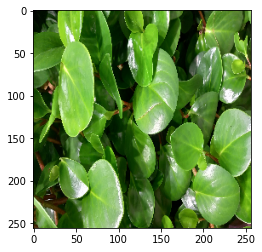

In [ ]:
import numpy as np
list=[]
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

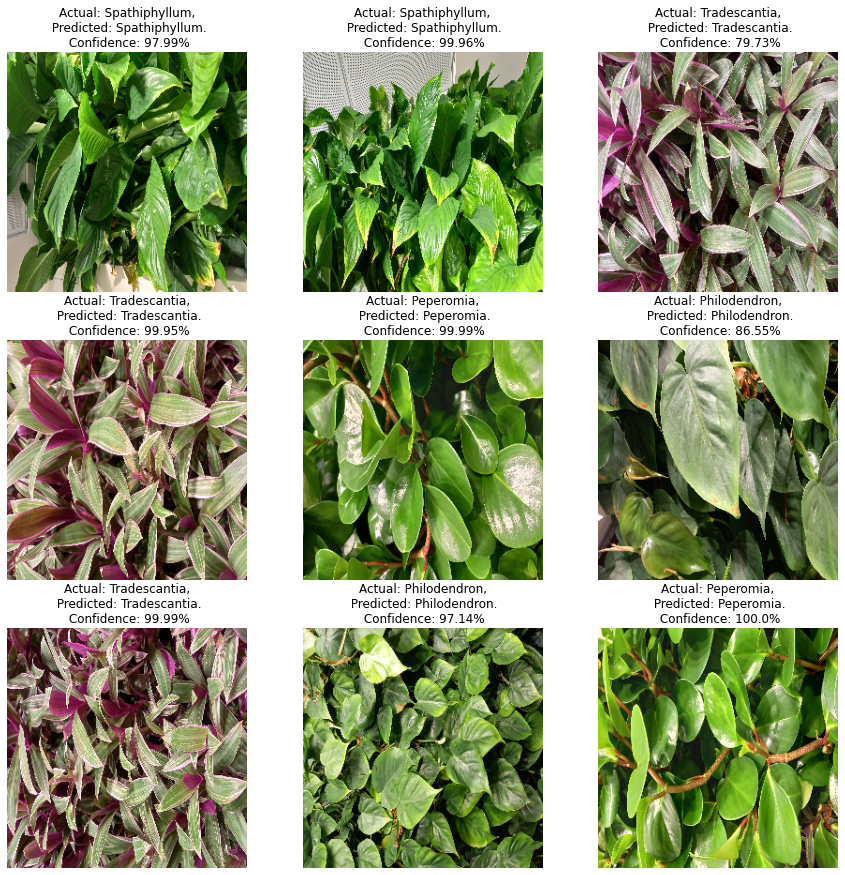

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### **Confusion matrix**

A confusion matrix helps us not only to get an overall score of the model but to see which of the classes is easy to predict well and which is not.

In [ ]:
y_test = np.concatenate([y for x, y in test_ds], axis=0) # true labals

In [ ]:
y_predicted = model.predict(test_ds) # predicted labels of the model
y_predicted_labels = [np.argmax(i) for i in y_predicted] # the label is the max value in the array

In [ ]:
# confusion matrix:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)
cm

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[10,  3,  0,  5,  1,  0],
       [ 0, 15,  1,  0,  0,  0],
       [ 0,  0, 12,  0,  3,  0],
       [ 1,  0,  0, 18,  0,  0],
       [ 0,  0,  0,  0, 20,  0],
       [ 1,  0,  0,  0,  0, 17]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

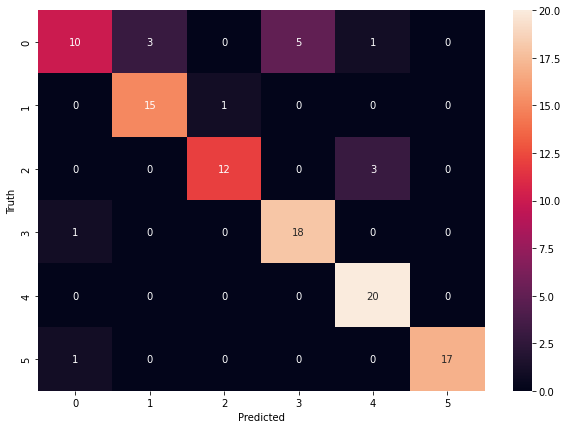

In [ ]:
#present the confusion matrix:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(69.0, 0.5, 'Truth')

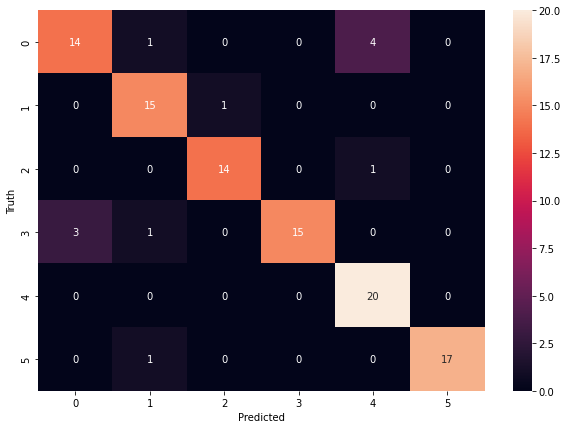

In [ ]:
# now lets do the same on the second model:

y_test = np.concatenate([y for x, y in test_ds], axis=0) # true labals
y_predicted = model1.predict(test_ds) # predicted labels of the model
y_predicted_labels = [np.argmax(i) for i in y_predicted] # the label is the max value in rhe array
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)
#present the confusion matrix:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## **Discussion**
 
 ⚡ The results show that **using video can be a very good way of collecting images for model building**. A model that practiced on video reaches an **accuracy of 86 %** with no difference if the validation set was also on video images. That is, video can be used for both training and validation. Although there is a difference between the plants that the different models are able to predict better - see above the confision matrix.

It is important to note that in our case there is a relatively low complication for the model that needs to distinguish many items in the same group (e.g. - a model who trained on video of dogs and cats may have more difficulty predicting a dog that **did not** appear in the training set).
In order to check if the accuracy is higher with more epoch i run the code again with 50 epoch (instead of 20) and the model predict the test dataset with 90% accuracy. you can see the code and results in my Github [here](https://github.com/yehuda-yu/DNN_plant_classification_model)

⚡ The third model I used gave prediction results of 0.2 percent accuracy on the test set. This could be due to the fact that **he did not fully trained on images that are not individual frames** of video.

  In addition, this is a model without hidden layers, so it will be interesting to add layers and see if the percentage of accuracy will increase significantly. In addition, there are other parameters that can be changed in the model itself (such as image size, number of repetitions, etc.)

   when we use **Transfer Learning** model (such this model) we excepy it to be more accurate so more work need to be done in order to understand why the accuracy is so low. 

 ⚡ **Future work** - in my next project i will try to do **segmentation Model** in order to distinguish between different plants in the same image. In this way I can run different models of carbon and water balances to identify from the image how much carbon is consumed by the plants and in addition how much water are emmited from the plants (in order to model the environmental impact of green walls)


## **Bibliography**

During my work i learn a lot from 2 different GitHub sourses. highly recommened to follow [codebasics](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbXJaREpxMG52QTJtZ3VlamQxU1JEWHJPeVpmUXxBQ3Jtc0tsQ3pOM3JYNjMwMWdhamI3T1NqWmQ5aG94QTlGeDJrY3FjSTBTS1FGQ2VZVllUOVJzQ2k0LVI5aktpOEZlZzdmaUdycXR3VV9jN0E1ZjdXclZrRTlZMERYVk83aU5mU2FHUVFqM085dTd6OUVkNGFCNA&q=https%3A%2F%2Fgithub.com%2Fcodebasics%2Fpotato-disease-classification) and [Krish Naik](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbGlSMlhIWERsempxSzNieDhUZTMzM3U1RzA2Z3xBQ3Jtc0tuRWVMOEo5Ynp2cjZUQklhM0Y2Y0cwdzZtdDdFbTlBQXNYeWQxWFZZR2E1M1FUSEVpWVJRMUY5clRhRXJFTnRydHRyVUpyaWlOUmMtYy1ITnVGWUJIeVNTVVBITHFhVzVuOHNfZ2xvMVg5UEN1aFpLWQ&q=https%3A%2F%2Fgithub.com%2Fkrishnaik06%2FTomato-Leaf-Disease-Prediction) about Data Science and Deep Learning models.
 
 1. The minimum number of images for DL in [this](https://petewarden.com/2017/12/14/how-many-images-do-you-need-to-train-a-neural-network/) blog (1000), and [this](https://arxiv.org/abs/2010.08186) academic paper

 2. Green walls enviromental effects - [here](https://www.mdpi.com/2673-4931/2/1/56)
